# 13. `dask`: Parallel Computations for Large Datasets

Some people think that large datasets or "big data" are mostly applied to machine learning and artificial intelligence fields. In atmospheric science, 

> Big data refers to data sets that are so voluminous and complex that traditional data processing application software is inadequate to deal with them.

Due to the long periods and finer grid resolutions of modern reanalysis data or model outputs, it often leads to system overload if not processed properly. You may see the following error message:

`MemoryError: Unable to allocate 52.2 GiB for an array with shape (365, 37, 721, 1440) and data type float32`

This error message appears because the data size has exceeded the RAM capacity. How should we avoid this situation?

## Dask Arrays

`dask` is a flexible library for parallel computing in Python. It can scale up to operate on large datasets and perform computations that cannot fit into memory. dask achieves this by breaking down large computations into smaller tasks, which are then executed in parallel. This can avoid consuming large amount of RAM. 

To understand the usage of dask, with demonstrate first with a 1000 × 4000 array size. 

**1. Numpy Array:**

In [1]:
import numpy as np

shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

**2. Dask Array:**

In [2]:
import dask.array as da

ones = da.ones(shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

![](https://docs.dask.org/en/latest/_images/dask-array.svg)

Dask devides the entire array into sub-arrays named "chunk". In `dask`, we can specify the size of a chunk.

In [3]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

We can do some arithmetic calculations, such as multiplication and averaging.

In [4]:
ones_mean = (ones * ones[::-1, ::-1]).mean()
ones_mean

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

Following is the calculation procedure:

![](https://earth-env-data-science.github.io/_images/dask_arrays_16_0.png)

Dask allows computation of each chunk in each memory core, and finally combines all the computation of each chunk to a final result.  Dask integrates commonly-used functions in `numpy` and `xarray`, which is beneficial to processing climate data. Then how will `dask` help with large datasets? In the following sections, we will demonstrate two types of workflow that will leverage the usage of `dask` to elevate computation efficiency. 


## Dask Environment Setup

We add the following codes before we proceed to primary computation jobs. 

In [5]:
from dask import delayed, compute
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(threads_per_worker=1, memory_limit=0)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:46085' processes=64 threads=64>

- `LocalCluster`: Used to start multiple workers on the local machine for parallel computation
- `Client`: Connects to the scheduler and handles communication between your Python session and the cluster. Every computation job is submitted to the workers through the client.
- `cluster = LocalCluster(threads_per_worker=1, memory_limit=0)`: Creates a local cluster where each worker runs on a single thread. Here the memory limit is set to 0 (no restriction). Be cautious: if the dataset is too large or the workflow is poorly designed, this may overload the available RAM. In practice, you can set the memory limit explicitly (e.g., `"4GB"`, `"8GB"`, `"16GB"`) to protect your system.
- `client = Client(cluster)`: Initializes a client object that communicates with the cluster. This ensures all Dask operations (e.g., loading large NetCDF/GRIB files with xarray, or delayed computations) are distributed to the workers via the scheduler.

There is also a link to the Client Dashboard. You can click to monitor your LocalCluster in real time.

![](https://tutorial.dask.org/_images/distributed-overview.png)

## Large Climate Dataset Processing

In Unit 2, we introduced the `parallel=True` option in `xarray.open_mfdataset`. This option allows `xarray` to read the file using `dask`.  

In [6]:
import xarray as xr

u = xr.open_mfdataset('./data/ncep_r2_uv850/u850.*.nc',
                           combine = "by_coords",               
                           parallel=True,
                         ).uwnd
v = xr.open_mfdataset('data/ncep_r2_uv850/v850.*.nc',
                           combine = "by_coords",               
                           parallel=True,
                         ).vwnd
u

<xarray.DataArray 'uwnd' (time: 8766, level: 1, lat: 73, lon: 144)> Size: 369MB
dask.array<concatenate, shape=(8766, 1, 73, 144), dtype=float32, chunksize=(366, 1, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 4B 850.0
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

At this point, `u` is a **Dask-backed DataArray**, not a full in-memory NumPy array. At this point, no actual data is read into RAM yet. The DataArray only stores metadata: dimensions, coordinates, data type, chunking info. Hence, the `u` array is very small (only a few MB regardless of how big your NetCDF files). 

Although xarray automatically chunks the dataset when using `xr.open_mfdataset()`, you can rechunk manually as follow:


In [7]:
from xarray.groupers import TimeResampler

u_rechunk = u.chunk({'time': TimeResampler("YS"), 'lon': 36, 'lat': 24})
u_rechunk

<xarray.DataArray 'uwnd' (time: 8766, level: 1, lat: 73, lon: 144)> Size: 369MB
dask.array<rechunk-p2p, shape=(8766, 1, 73, 144), dtype=float32, chunksize=(366, 1, 24, 36), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 4B 850.0
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

Manual rechunking is particularly useful when the dataset is very large and the automatic chunking produces too many small chunks, which can lead to high scheduling overhead in Dask.

Practical guidelines for chunk sizing:
- Aim for chunk sizes roughly 50–200 MB each. This is large enough to reduce overhead but small enough to fit in RAM comfortably.
- Avoid having too many chunks per dimension (e.g., hundreds or thousands), because Dask has to manage each chunk as a separate task, which can slow down the computation.

Read more details on how to choose good chunk sizes [here](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes?utm_source=xarray-docs).

```{note}
You can use `ds.chunk(time=TimeResampler())` to rechunk according to a specified unit of time. `ds.chunk(time=TimeResampler("MS"))`, for example, will set the chunks so that a month of data is contained in one chunk.
```

### `.compute()`

The data will be actually loaded into RAM when `.compute()` is called.  Therefore, it is a good practice to slice or subset your datasets before calling `.compute()`, especially when working with large NetCDF or GRIB files, to avoid memory overload.


In [8]:
u_slice = u.sel(lat=slice(90,0)).compute()
v_slice = v.sel(lat=slice(90,0)).compute()
u_slice

<xarray.DataArray 'uwnd' (time: 8766, level: 1, lat: 37, lon: 144)> Size: 187MB
array([[[[ -7.9900055 ,  -7.9600067 ,  -7.9400024 , ...,  -7.9799957 ,
           -7.9600067 ,  -8.0099945 ],
         [ -3.5800018 ,  -3.2900085 ,  -3.0099945 , ...,  -4.5099945 ,
           -4.2100067 ,  -3.8600006 ],
         [  4.1900024 ,   4.669998  ,   5.050003  , ...,   2.4199982 ,
            3.069992  ,   3.699997  ],
         ...,
         [ -2.5400085 ,  -3.6100006 ,  -4.1600037 , ...,   0.6199951 ,
           -0.21000671,  -1.3399963 ],
         [ -4.1100006 ,  -4.630005  ,  -4.3099976 , ...,  -0.29000854,
           -1.4900055 ,  -2.9100037 ],
         [ -7.4600067 ,  -7.3899994 ,  -6.1900024 , ...,  -3.6600037 ,
           -5.2299957 ,  -6.6100006 ]]],


       [[[ -5.6100006 ,  -5.1600037 ,  -4.7100067 , ...,  -6.8099976 ,
           -6.4100037 ,  -6.0099945 ],
         [  2.2200012 ,   2.6699982 ,   3.069992  , ...,   0.56999207,
            1.199997  ,   1.6900024 ],
         [  8.319992  ,   8.789993  ,   9.139999  , ...,   6.369995  ,
...
            1.6250005 ,   1.9250002 ],
         [ -1.2750001 ,  -0.7999997 ,  -0.2249999 , ...,  -2.7249997 ,
           -2.2       ,  -1.7499998 ],
         [ -3.9249995 ,  -3.4999998 ,  -2.9250002 , ...,  -5.4       ,
           -4.975     ,  -4.5       ]]],


       [[[ -6.7499995 ,  -6.775     ,  -6.8250003 , ...,  -6.6       ,
           -6.625     ,  -6.7249994 ],
         [ -6.8749995 ,  -6.925     ,  -6.9499993 , ...,  -6.575     ,
           -6.675     ,  -6.775     ],
         [ -7.05      ,  -7.175     ,  -7.225     , ...,  -6.5000005 ,
           -6.725     ,  -6.8749995 ],
         ...,
         [ -0.625     ,  -0.8500004 ,  -0.5750003 , ...,  -2.6       ,
           -1.5500002 ,  -0.7249999 ],
         [ -1.6749997 ,  -1.3499999 ,  -1.2750001 , ...,  -5.9500003 ,
           -4.4749994 ,  -2.775     ],
         [ -3.15      ,  -2.8249998 ,  -2.8250003 , ...,  -7.700001  ,
           -6.125     ,  -4.3       ]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 148B 90.0 87.5 85.0 82.5 80.0 ... 7.5 5.0 2.5 0.0
  * level    (level) float32 4B 850.0
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

Since Dask is well integrated with `numpy` and `xarray` functions, it is also a good idea to call `.compute()` after using intrinsic functions. For example, to calculate the time mean of the wind field:

In [9]:
u_mean = u.mean(axis=0).compute()
v_mean = v.mean(axis=0).compute()
u_mean

<xarray.DataArray 'uwnd' (level: 1, lat: 73, lon: 144)> Size: 42kB
array([[[-0.633123  , -0.647495  , -0.660538  , ..., -0.58317655,
         -0.60082316, -0.61727756],
        [-0.25697124, -0.2630875 , -0.26836646, ..., -0.23004168,
         -0.24033782, -0.24917528],
        [ 0.04172542,  0.02860714,  0.02494916, ...,  0.14124975,
          0.0976802 ,  0.06451849],
        ...,
        [-5.6017437 , -5.16407   , -4.7215905 , ..., -6.8395767 ,
         -6.444315  , -6.0301476 ],
        [-4.247105  , -3.8827536 , -3.5130305 , ..., -5.2855477 ,
         -4.949826  , -4.6035438 ],
        [ 0.21703638,  0.56360835,  0.9087125 , ..., -0.82172674,
         -0.47649175, -0.12961623]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 4B 850.0

### `.persist()`

Every `.compute()` triggers the *entire* task graph from beginning: reading the original NetCDF/GRIB files from disk, chunking the data, performing intermidiate computations, and producing the final results. Supoose we'd like to do various statistical computation on `u`, such as 

```python
umean = u.mean(axis=0).compute()
uvar  = u.var(axis=0).compute()
umed  = u.median(axis=0).compute()
umax  = u.max(axis=0).compute()
umin  = u.min(axis=0).compute()
```

Those process from reading original NetCDF files to produce `u` will be repeated once per line of computation that uses `u`, leading to redundant work and inefficiency. Therefore, `.persist()` triggers computation of parts of the task graph and stores the resulting chunks in the cluster workers' memory (RAM). Subsequent computations based on the persisted variables will directly use the in-memory chunks, avoiding repeated reading and intermediate computations.

In [10]:
u_persist = u.persist()
v_persist = v.persist()

To sum up, use `.persist()` when you have a core variable (like `u` in this example) that will be used multiple times. But also be mindful of worker memory usage: if the dataset is very large, persisting may fill up RAM. In that case, consider rechunking or persisting only a subset (e.g., a time slice).

**Example 1:** Calculate the *daily climatology* of `u` and `v`.

We will compute the daily climatology with the [`flox.xarray.xarray_reduce`](https://flox.readthedocs.io/en/latest/generated/flox.xarray.xarray_reduce.html) libray. The input wind fields are the *persisted* variables. 

In [11]:
from flox.xarray import xarray_reduce

uDayClm = xarray_reduce(u_persist,
                        u_persist.time.dt.dayofyear,
                        func='mean',dim='time')
vDayClm = xarray_reduce(v_persist,
                        v_persist.time.dt.dayofyear,
                        func='mean',dim='time')
uDayClm 

<xarray.DataArray 'uwnd' (dayofyear: 366, level: 1, lat: 73, lon: 144)> Size: 15MB
dask.array<transpose, shape=(366, 1, 73, 144), dtype=float32, chunksize=(366, 1, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * level      (level) float32 4B 850.0
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

After lazy computation, we can now really trigger computation and return the final result with `.compute()`.

In [12]:
uDayClm_fn = uDayClm.compute()
vDayClm_fn = vDayClm.compute()

uDayClm_fn

<xarray.DataArray 'uwnd' (dayofyear: 366, level: 1, lat: 73, lon: 144)> Size: 15MB
array([[[[-1.5247937e+00, -1.4514604e+00, -1.3754172e+00, ...,
          -1.7235428e+00, -1.6562518e+00, -1.5960444e+00],
         [-5.6333429e-01, -4.1833475e-01, -2.7458504e-01, ...,
          -9.6874976e-01, -8.4125155e-01, -6.9416922e-01],
         [ 7.5583190e-01,  9.2770594e-01,  1.0993727e+00, ...,
           3.0166462e-01,  4.4770643e-01,  6.0145718e-01],
         ...,
         [-2.1635435e+00, -1.9181260e+00, -1.6775018e+00, ...,
          -2.8645859e+00, -2.6393764e+00, -2.4029195e+00],
         [-2.3662536e+00, -2.1679192e+00, -1.9677110e+00, ...,
          -2.9314604e+00, -2.7418773e+00, -2.5595868e+00],
         [-7.0416862e-01, -5.3041750e-01, -3.5291770e-01, ...,
          -1.2106274e+00, -1.0472922e+00, -8.7396073e-01]]],


       [[[ 1.3624781e-01,  1.8458217e-01,  2.3916422e-01, ...,
          -1.3961315e-02,  3.6873043e-02,  8.3957411e-02],
         [ 2.3895724e-01,  3.3770636e-01,  4.3708053e-01, ...,
          -5.7292778e-02,  4.5207102e-02,  1.4082973e-01],
         [ 2.3937146e-01,  3.5499719e-01,  4.8520657e-01, ...,
...
         [-2.1402094e+00, -1.9437499e+00, -1.7400008e+00, ...,
          -2.7075014e+00, -2.5300019e+00, -2.3356268e+00],
         [-2.5000751e-02,  1.4437424e-01,  3.1728974e-01, ...,
          -5.3333282e-01, -3.6312675e-01, -1.9583400e-01]]],


       [[[-4.1091676e+00, -3.9441681e+00, -3.7783356e+00, ...,
          -4.5566688e+00, -4.4050002e+00, -4.2674980e+00],
         [-3.2116699e+00, -3.1075017e+00, -2.9991691e+00, ...,
          -3.5141671e+00, -3.4233353e+00, -3.3258324e+00],
         [-3.0250015e+00, -3.1033335e+00, -3.1783364e+00, ...,
          -2.5975020e+00, -2.7550004e+00, -2.8883379e+00],
         ...,
         [-2.2550049e+00, -1.9391688e+00, -1.6375014e+00, ...,
          -3.1650000e+00, -2.8641689e+00, -2.5591679e+00],
         [-1.5691684e+00, -1.3050017e+00, -1.0416707e+00, ...,
          -2.3041666e+00, -2.0675030e+00, -1.8150015e+00],
         [ 1.0366653e+00,  1.2341684e+00,  1.4316640e+00, ...,
           4.0583149e-01,  6.1833334e-01,  8.4499711e-01]]]],
      dtype=float32)
Coordinates:
  * lon        (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * level      (level) float32 4B 850.0
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

The computed result is now saved in a DataArray. 

### Takeaway

In this example, our dataset is relatively small, so the advantage of using `persist()` and lazy computation may not be obvious.  However, the workflow we practiced:
1. Open data lazily with Dask  
2. Decide chunking strategy  
3. Use `.persist()` for frequently reused core variables  
4. Use `.compute()` only when results are truly needed  

This is exactly the same workflow that will scale up to very large climate datasets (e.g., high resolution ERA5 reanalysis, multi-dacade CMIP6 data, or high resolution ensemble model reforecast GEFSv12 data).  

## Loops with Parallel Computation

Sometimes, intrinsic functions cannot directly be applied to our analysis procedure. Therefore, we have to loop over different index for several times. We can wrap this workflow into a function, and then run the function across a loop in **parallel** using Dask.  For example, if we have 8 iterations in a loop and 8 available cores (workers), Dask can distribute each iteration to a separate core. In ideal conditions, this can reduce the total loop runtime roughly to the time of a **single iteration**, since the 8 iterations are computed simultaneously. This approach allows us to take full advantage of multiple cores without manually managing threads or processes.

**Example 2:** Plot precipitation and 850-hPa wind composite for each MJO phase in DJF months. 

**Step 1:** Read BoM RMM index, which can be accessed from [IRI data library](https://iridl.ldeo.columbia.edu/SOURCES/.BoM/.MJO/.RMM/datasetdatafiles.html?Set-Language=en).

In [13]:
import pandas as pd

# Read MJO data
mjo_ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.BoM/.MJO/.RMM/dods',
                         decode_times=False)

T = mjo_ds.T.values
mjo_ds['T'] = pd.date_range("1974-06-01", periods=len(T))  # 資料的起始時間為1974-06-01

mjo_sig_phase = xr.where(mjo_ds.amplitude>=1,  mjo_ds.phase, 0)
mjo_slice = mjo_sig_phase.sel(T=slice("1998-01-01","2020-12-31"))
mjo_djf = mjo_slice.sel(T=mjo_slice['T'].dt.month.isin([12, 1, 2]))

syntax error, unexpected WORD_STRING, expecting ';' or ','
context: Attributes { T { String calendar "standard"; Int32 expires 1755648000; String standard_name "time"; Float32 pointwidth 1.0; Int32 gridtype 0; String units "julian_day"; } amplitude { Int32 expires 1755648000; String units "unitless"; Float32 missing_value 9.99999962E35; } phase { Int32 expires 1755648000; String units "unitless"; Float32 missing_value 999.0; } RMM1 { Int32 expires 1755648000; String units "unitless"; Float32 missing_value 9.99999962E35; } RMM2 { Int32 expires 1755648000; String units "unitless"; Float32 missing_value 9.99999962E35; }NC_GLOBAL { String references "Wheeler_Hendon2004"; Int32 expires 1755648000; URL data source "http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt"^; String description "Real-time Multivariate MJO Index (with components of interannual variability removed)"; URL summary from BoM "http://www.bom.gov.au/climate/mjo/"; URL Wheeler and Hendon (2004) Monthly Weather R

**Step 2:** Read data. 

In [14]:
def calc_anml_slice(da): 
    da_slice = da.sel(time=slice("1998-01-01","2020-12-31"),lat=slice(20,-20),lon=slice(40,180)).chunk({'time': TimeResampler("YS")})
    da_anml = da_slice.groupby('time.dayofyear') - da_slice.groupby('time.dayofyear').mean('time')  # Anomaly
    da_djf = da_anml.sel(time=da_anml.time.dt.month.isin([12, 1, 2])) 
    return da_djf

pcp = xr.open_dataset('./data/cmorph_sample.nc').cmorph
pcp = pcp[:,::-1,:]  # Re-order latitude from north to south (same as u and v)

# Calculate OLR and wind anomaly 
pcpa = calc_anml_slice(pcp)
ua   = calc_anml_slice(u.isel(level=0))
va   = calc_anml_slice(v.isel(level=0))

pcpa

<xarray.DataArray 'cmorph' (time: 2076, lat: 160, lon: 560)> Size: 744MB
dask.array<getitem, shape=(2076, 160, 560), dtype=float32, chunksize=(216, 160, 560), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 17kB 1998-01-01 1998-01-02 ... 2020-12-31
  * lon        (lon) float32 2kB 40.12 40.38 40.62 40.88 ... 179.4 179.6 179.9
  * lat        (lat) float32 640B 19.88 19.62 19.38 ... -19.38 -19.62 -19.88
    dayofyear  (time) int64 17kB 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

### Serial Procedure

**Step 3:** Compute composite MJO-OLR and wind fields. 

We will first demonstrate the serial computation:

In [15]:
mjo_pcp, mjo_u, mjo_v = [], [], []

for i in range(1,9):
    mjo_phase = xr.where(mjo_djf==i, mjo_djf, np.nan).dropna(dim='T')
    time = mjo_phase['T']
    
    pcp_compo_mean = (pcpa.loc[time,:,:]
                          .mean(axis=0)
                          .expand_dims(phase=[i],axis=0))
    u_compo_mean = (ua.loc[time,:,:]
                      .mean(axis=0)
                      .expand_dims(phase=[i],axis=0))
    v_compo_mean = (va.loc[time,:,:]
                      .mean(axis=0)
                      .expand_dims(phase=[i],axis=0))
    
    mjo_pcp.append(pcp_compo_mean)
    mjo_u.append(u_compo_mean)
    mjo_v.append(v_compo_mean)

mjo_pcp_fn = xr.concat(mjo_pcp, dim='phase').compute()
mjo_u_fn = xr.concat(mjo_u, dim='phase').compute()
mjo_v_fn = xr.concat(mjo_v, dim='phase').compute()

mjo_pcp_fn

<xarray.DataArray 'cmorph' (phase: 8, lat: 160, lon: 560)> Size: 3MB
array([[[ 1.1642029 ,  1.7967764 ,  1.6354021 , ..., -0.49765617,
         -0.52265364, -0.3197551 ],
        [ 0.4289805 ,  0.5675261 ,  0.7982411 , ..., -0.37138933,
         -0.37802598, -0.2736282 ],
        [ 0.34693143,  0.09691156,  0.4446028 , ..., -0.274023  ,
         -0.31316844, -0.3483858 ],
        ...,
        [-0.26494256,  0.6725488 ,  0.36411816, ..., -3.3324733 ,
         -2.380455  , -2.077746  ],
        [ 0.2235834 ,  0.666082  ,  0.08555231, ..., -2.9516845 ,
         -2.7592201 , -2.5683365 ],
        [ 1.033728  ,  1.054208  ,  0.6711898 , ..., -2.9339333 ,
         -2.7459626 , -2.7602105 ]],

       [[-0.2819479 , -0.35855076, -0.27372763, ..., -0.42099413,
         -0.44489563, -0.30963767],
        [-0.22117391, -0.26832473, -0.27131033, ..., -0.4018956 ,
         -0.39008692, -0.34509283],
        [-0.20414495, -0.23193039, -0.24091023, ..., -0.12682611,
         -0.26710433, -0.2954261 ],
...
        [ 2.318648  ,  1.3489722 ,  0.8619659 , ...,  1.837919  ,
          1.5916772 ,  0.8387357 ],
        [ 2.0905535 ,  1.4776336 ,  1.1018339 , ...,  1.8853862 ,
          1.351057  ,  0.982385  ],
        [ 1.9134518 ,  1.6720352 ,  1.401461  , ...,  1.6543014 ,
          1.0584089 ,  1.0382332 ]],

       [[ 0.9606286 ,  0.6415049 ,  0.3561331 , ..., -0.59736055,
         -0.61483186, -0.6769132 ],
        [ 0.6706844 ,  0.565837  ,  0.70489025, ..., -0.6471602 ,
         -0.67367876, -0.69084775],
        [ 0.47901937,  0.6756892 ,  0.75941104, ..., -0.7043601 ,
         -0.71212757, -0.65451425],
        ...,
        [ 1.3432965 ,  1.0880604 ,  0.6569935 , ..., -1.3948476 ,
         -1.3313782 , -1.1290971 ],
        [ 1.608773  ,  1.8569999 ,  1.5715383 , ..., -1.7065433 ,
         -0.95375925, -0.62605035],
        [ 2.4226344 ,  2.9898245 ,  2.7392473 , ..., -2.171187  ,
         -1.9004679 , -1.6571506 ]]], dtype=float32)
Coordinates:
  * phase    (phase) int64 64B 1 2 3 4 5 6 7 8
  * lon      (lon) float32 2kB 40.12 40.38 40.62 40.88 ... 179.4 179.6 179.9
  * lat      (lat) float32 640B 19.88 19.62 19.38 19.12 ... -19.38 -19.62 -19.88

In the serial computation, computation proceeds phase by phase, so only one worker is active at a time.

### Parallel Procedure

Since each phase composite is **independent**, we can parallelize the loop with Dask. The idea is:

1. Wrap the composite calculation for one phase into a function.
2. Use `dask.delayed` to build tasks for all eight phases without executing them immediately.
3. Call `compute()` once, letting Dask schedule and run all phase composites in parallel across multiple workers.

In [16]:
from dask import delayed, compute

@delayed
def compute_phase_composite(phase, mjo_djf, pcpa, ua, va):
    """Compute composite mean for one MJO phase"""
    mjo_phase = xr.where(mjo_djf == phase, mjo_djf, np.nan).dropna(dim='T')
    time = mjo_phase['T']

    pcp_compo_mean = (pcpa.loc[time,:,:]
                          .mean(axis=0)
                          .expand_dims(phase=[phase], axis=0))
    u_compo_mean   = (ua.loc[time,:,:]
                          .mean(axis=0)
                          .expand_dims(phase=[phase], axis=0))
    v_compo_mean   = (va.loc[time,:,:]
                          .mean(axis=0)
                          .expand_dims(phase=[phase], axis=0))
    
    return pcp_compo_mean, u_compo_mean, v_compo_mean

# build delayed tasks for each phase
tasks = [compute_phase_composite(i, mjo_djf, pcpa, ua, va) for i in range(1, 9)]

# execute all phases in parallel
results = compute(*tasks)

# unpack results
mjo_pcp_list, mjo_u_list, mjo_v_list = zip(*results)

# concat along phase dimension
mjo_pcp_fn = xr.concat(mjo_pcp_list, dim='phase')
mjo_u_fn   = xr.concat(mjo_u_list, dim='phase')
mjo_v_fn   = xr.concat(mjo_v_list, dim='phase')

mjo_pcp_fn


<xarray.DataArray 'cmorph' (phase: 8, lat: 160, lon: 560)> Size: 3MB
array([[[ 1.1642029 ,  1.7967764 ,  1.6354021 , ..., -0.49765617,
         -0.52265364, -0.3197551 ],
        [ 0.4289805 ,  0.5675261 ,  0.7982411 , ..., -0.37138933,
         -0.37802598, -0.2736282 ],
        [ 0.34693143,  0.09691156,  0.4446028 , ..., -0.274023  ,
         -0.31316844, -0.3483858 ],
        ...,
        [-0.26494256,  0.6725488 ,  0.36411816, ..., -3.3324733 ,
         -2.380455  , -2.077746  ],
        [ 0.2235834 ,  0.666082  ,  0.08555231, ..., -2.9516845 ,
         -2.7592201 , -2.5683365 ],
        [ 1.033728  ,  1.054208  ,  0.6711898 , ..., -2.9339333 ,
         -2.7459626 , -2.7602105 ]],

       [[-0.2819479 , -0.35855076, -0.27372763, ..., -0.42099413,
         -0.44489563, -0.30963767],
        [-0.22117391, -0.26832473, -0.27131033, ..., -0.4018956 ,
         -0.39008692, -0.34509283],
        [-0.20414495, -0.23193039, -0.24091023, ..., -0.12682611,
         -0.26710433, -0.2954261 ],
...
        [ 2.3186479 ,  1.3489723 ,  0.8619657 , ...,  1.8379189 ,
          1.5916773 ,  0.8387354 ],
        [ 2.0905535 ,  1.4776337 ,  1.1018339 , ...,  1.8853862 ,
          1.351057  ,  0.9823849 ],
        [ 1.913452  ,  1.6720352 ,  1.4014612 , ...,  1.6543014 ,
          1.0584089 ,  1.0382335 ]],

       [[ 0.9606286 ,  0.6415049 ,  0.3561331 , ..., -0.59736055,
         -0.61483186, -0.6769132 ],
        [ 0.6706844 ,  0.565837  ,  0.70489025, ..., -0.6471602 ,
         -0.67367876, -0.69084775],
        [ 0.47901937,  0.6756892 ,  0.75941104, ..., -0.7043601 ,
         -0.71212757, -0.65451425],
        ...,
        [ 1.3432965 ,  1.0880604 ,  0.6569935 , ..., -1.3948476 ,
         -1.3313782 , -1.1290971 ],
        [ 1.608773  ,  1.8569999 ,  1.5715383 , ..., -1.7065433 ,
         -0.95375925, -0.62605035],
        [ 2.4226344 ,  2.9898245 ,  2.7392473 , ..., -2.171187  ,
         -1.9004679 , -1.6571506 ]]], dtype=float32)
Coordinates:
  * phase    (phase) int64 64B 1 2 3 4 5 6 7 8
  * lon      (lon) float32 2kB 40.12 40.38 40.62 40.88 ... 179.4 179.6 179.9
  * lat      (lat) float32 640B 19.88 19.62 19.38 19.12 ... -19.38 -19.62 -19.88

The `@delayed` decorator before the `compute_phase_composite()` function is used to turn a normal Python function into a lazy task. Normally, when you call a function in Python, it executes immediately and returns a result. But with `@delayed`, the function call does **not** execute right away. Instead, it returns a **Delayed object** that represents a task in a computation graph.  

When you collect many Delayed objects (e.g., inside a loop), Dask can build a full task graph. The actual computation happens only when you explicitly call `.compute()` (or `dask.compute(...)`), at which point Dask will schedule the tasks across multiple workers and run them in parallel.  

```{note}
In this MJO composite example, the computation itself is relatively light. Each task only selects a subset of time indices, takes a simple mean, and returns a result.  

Because the operations are small, the overhead from Dask’s scheduler (building the task graph, coordinating workers, handling chunk shuffles) can be comparable to, or even larger than, the actual computation time. As a result, you may not see a big speed-up compared to the serial version.  

The real advantage of using Dask’s `@delayed` (or Dask arrays in general) appears when:  

- The dataset is very large (tens or hundreds of GBs).  
- Each task is computationally heavy.   

So while this example is only a demonstration on how to structure loops for parallel computation, the performance benefits will be more obvious in larger, more demanding workflows.
```


**Step 4:** Plotting

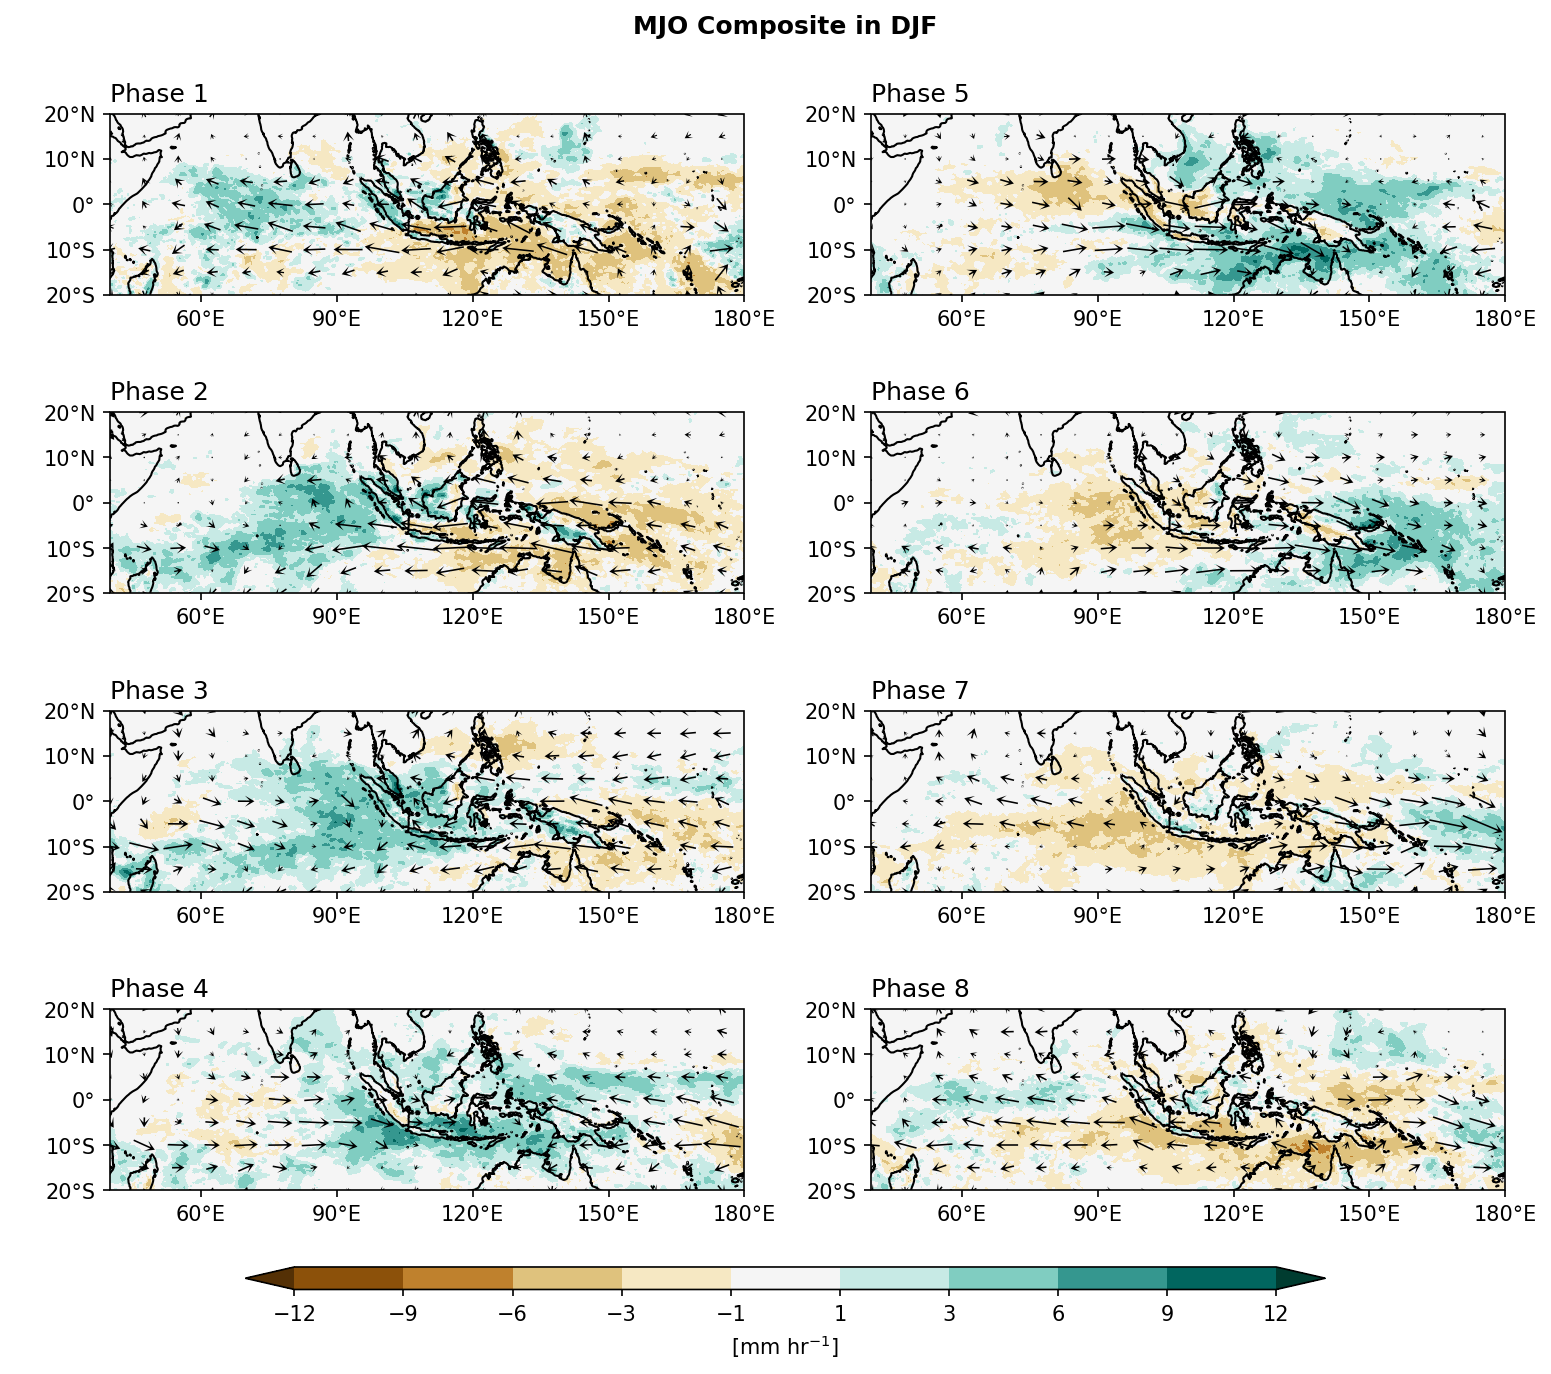

In [27]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmaps
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

mpl.rcParams['figure.dpi'] = 150

fig, axes = plt.subplots(4,2, 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(12,10))
ax = axes.flatten()
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER

clevs = [-12,-9,-6,-3,-1,1,3,6,9,12]

porder = [0,2,4,6,1,3,5,7]

for i in range(0,8): 
    cf = (mjo_pcp_fn[i,:,:].plot.contourf(x='lon',y='lat', ax=ax[porder[i]],
                                         levels=clevs,
                                         add_colorbar=False,
                                         cmap=cmaps.CBR_drywet, 
                                         extend='both',
                                         transform=ccrs.PlateCarree()))
    wnd = xr.merge([mjo_u_fn[i,::2,::3], mjo_v_fn[i,::2,::3]])
    qv = wnd.plot.quiver(ax=ax[porder[i]],
                         transform=ccrs.PlateCarree(),
                         x='lon', y='lat',
                         u='uwnd', v='vwnd',
                         add_guide=False,
                         width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                         scale=70, colors="black"
                         )
    
    ax[porder[i]].coastlines()
    ax[porder[i]].set_extent([40,180,-20,20],crs=ccrs.PlateCarree())
    ax[porder[i]].set_xticks(np.arange(60,210,30), crs=ccrs.PlateCarree())
    ax[porder[i]].set_yticks(np.arange(-20,30,10), crs=ccrs.PlateCarree())   # 設定x, y座標的範圍，以及多少經緯度繪製刻度。
    ax[porder[i]].xaxis.set_major_formatter(lon_formatter)
    ax[porder[i]].yaxis.set_major_formatter(lat_formatter)
    ax[porder[i]].set_xlabel(' ')
    ax[porder[i]].set_ylabel(' ')
    ax[porder[i]].set_title(' ')
    ax[porder[i]].set_title('Phase '+str(i+1), loc='left')
    
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.07, 0.6, 0.015])
# Draw the colorbar 將colorbar畫在cbar_ax這個軸上。
cbar = fig.colorbar(cf, cax=cbar_ax,
                    orientation='horizontal',
                    ticks=clevs,
                    label=r'[mm hr$^{-1}$]')  

plt.subplots_adjust(hspace=0.15)
plt.suptitle('MJO Composite in DJF',y=0.92,size='large',weight='bold')
plt.show()    